# Adadelta --- 使用Gluon

在`Gluon`里，使用Adadelta很容易。我们无需重新实现它。

In [1]:
import mxnet as mx
from mxnet import autograd
from mxnet import gluon
from mxnet import ndarray as nd
import numpy as np
import random

mx.random.seed(1)
random.seed(1)

# 生成数据集。
num_inputs = 2
num_examples = 1000
true_w = [2, -3.4]
true_b = 4.2
X = nd.random_normal(scale=1, shape=(num_examples, num_inputs))
y = true_w[0] * X[:, 0] + true_w[1] * X[:, 1] + true_b
y += .01 * nd.random_normal(scale=1, shape=y.shape)
dataset = gluon.data.ArrayDataset(X, y)

net = gluon.nn.Sequential()
net.add(gluon.nn.Dense(1))
square_loss = gluon.loss.L2Loss()

我们需要在`gluon.Trainer`中指定优化算法名称`adadelta`并设置rho参数。

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def train(batch_size, rho, epochs, period):
    assert period >= batch_size and period % batch_size == 0
    net.collect_params().initialize(mx.init.Normal(sigma=1), force_reinit=True)
    # Adadelta。
    trainer = gluon.Trainer(net.collect_params(), 'adadelta',
                            {'rho': rho})
    data_iter = gluon.data.DataLoader(dataset, batch_size, shuffle=True)
    total_loss = [np.mean(square_loss(net(X), y).asnumpy())]
    
    for epoch in range(1, epochs + 1):
        for batch_i, (data, label) in enumerate(data_iter):
            with autograd.record():
                output = net(data)
                loss = square_loss(output, label)
            loss.backward()
            trainer.step(batch_size)

            if batch_i * batch_size % period == 0:
                total_loss.append(np.mean(square_loss(net(X), y).asnumpy()))
        print("Batch size %d, Epoch %d, loss %.4e" % 
              (batch_size, epoch, total_loss[-1]))

    print('w:', np.reshape(net[0].weight.data().asnumpy(), (1, -1)), 
          'b:', net[0].bias.data().asnumpy()[0], '\n')
    x_axis = np.linspace(0, epochs, len(total_loss), endpoint=True)
    plt.semilogy(x_axis, total_loss)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.show()

使用Adadelta，最终学到的参数值与真实值较接近。

Batch size 10, Epoch 1, loss 8.2180e-05


Batch size 10, Epoch 2, loss 4.9327e-05


Batch size 10, Epoch 3, loss 4.9216e-05
w: [[ 2.00076938 -3.39997005]] b: 4.19921 



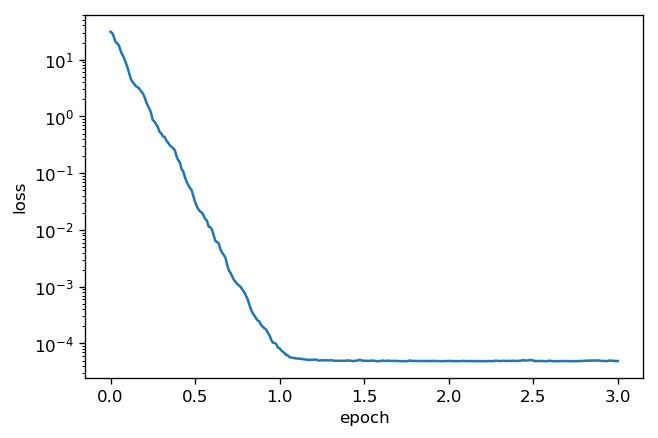

In [3]:
train(batch_size=10, rho=0.9999, epochs=3, period=10)

## 结论

* 使用`Gluon`的`Trainer`可以轻松使用Adadelta。

## 练习

* 如果把试验中的参数rho改小会怎样，例如0.9？观察实验结果。

**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/2278)